<a href="https://colab.research.google.com/github/Arisha-27/Network_Fingerprinting/blob/main/Network_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from google.colab import drive
import os


In [ ]:
drive.mount('/content/drive')

folder = '/content/drive/MyDrive/CIC-IDS/'
all_files = [
    'Monday-WorkingHours.pcap_ISCX.csv',
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Wednesday-workingHours.pcap_ISCX.csv',
    'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'
]

df = pd.concat([pd.read_csv(os.path.join(folder, f)) for f in all_files], ignore_index=True)

Mounted at /content/drive


In [ ]:
df.columns = df.columns.str.strip()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

df.drop(columns=['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Protocol'], inplace=True, errors='ignore')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

df = df.sample(n=100000, random_state=42)

X = df.drop('Label', axis=1)
y = df['Label']

for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])


In [ ]:
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X, y)
selected_columns = X.columns[selector.get_support()]
X = X[selected_columns]

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [31 33 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

In [ ]:
model = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', verbose=1)
grid.fit(X_train_resampled, y_train_resampled)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


 Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}
Accuracy: 99.745 %

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16035
           1       0.99      1.00      0.99      3965

    accuracy                           1.00     20000
   macro avg       0.99      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Confusion Matrix:
 [[15997    38]
 [   13  3952]]


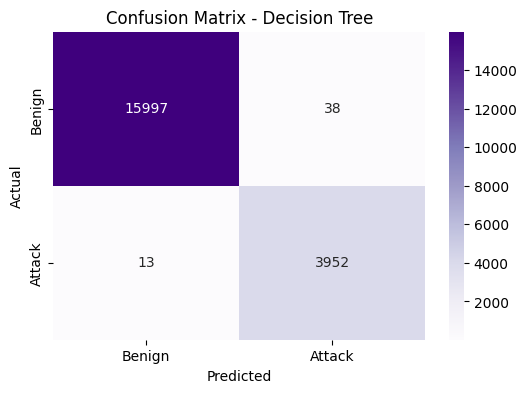

In [ ]:
print(" Best Parameters:", grid.best_params_)
print("Accuracy:", round(accuracy_score(y_test, y_pred)*100, 4), "%")
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Purples",
            xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()